# Adaptive PDE discretizations on cartesian grids

## Part : Monotone numerical schemes
## Chapter : PDEs with a second order non-linearity

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of non-linear PDEs, in two space dimensions. 
We consider Pucci's operator
$$
    \Lambda u(x) := \alpha(x) \lambda_{\max}(\nabla^2 u(x)) + \lambda_{\min}(\nabla^2 u(x))
$$
in the PDE
$$
    - \Lambda u(x) + \beta(x) = 0,
$$
with Dirichlet boundary conditions. The PDE parameters are a positive function $\alpha$, and an arbitrary function $\beta$.
We denote by $\lambda_{\max}(M)$ and $\lambda_{\min}(M)$ the largest and smallest eigenvalue of a positive definite tensor $M$. More details on this problem below.

We design two monotone numerical schemes: 
* The first sheme, based on a discretization of the space of controls, is simple to implement. However it is quite costly numerically, and it induces a consistency defect.
* The second scheme is second order consistent and possibly cheaper numerically. However, implementation details are more subtle.

The two schemes involves adaptive stencils, built using techniques from lattice geometry. The techniques developed are fairly general, and can be applied to a wide range of non-linear PDEs. Numerical implementation is kept simple thanks to the use of automatic differentiation.

## Discretization of the PDE

### Reformulation as an extremal operator

Assume without loss of generality that $\alpha \leq 1$. Then for any positive definite matrix $M$ one has 
$$
    \alpha \lambda_{\max}(M) + \lambda_{\min}(M) = \min_{0 \leq \theta \leq \pi} {\rm tr}(D_\alpha(\theta) M),
$$
where we denoted, with $e(\theta) := (\cos \theta, \sin \theta)$
$$
    D_\alpha(\theta) = \alpha\, e(\theta) e(\theta)^T + e(\theta)^\perp (e(\theta)^\perp)^T,
$$
the symmetric matrix whose eigenvalues are $\alpha$ and $1$, the former associated with the eigenvector $e(\theta)$.

**Remark on the range of the variable $\theta$.**
For any $\theta\in \mathbb R$, one has $e(\theta+\pi) = -e(\theta)$, and therefore $D_\alpha(\theta+\pi) = D_\alpha(\theta)$. By periodicity, we may therefore limit our attention to the interval $[0,\pi]$.

**Remark on the case $\alpha\geq 1$.**
This second case is handled by replacing the minimum over $\theta\in [0,\pi]$ with a maximum. This does not induce any additional difficulty from the theoretical or numerical standpoints. However, for the sake of simplicity, we make the assumption that $\alpha\leq 1$ in the following.

### A monotone discretization strategy : sampling the control space

Let $K$ be a positive integer, and let $\theta_1 \leq \cdots \leq \theta_K$ be a sampling of the interval $[0,\pi]$. Then we may consider the approximate operator
$$
    \Lambda_K u(x) := \min_{1 \leq k \leq K} {\rm tr} (D_\alpha(\theta_k) \nabla^2 u(x)).
$$
Introduce decompositions of the tensors, obtained e.g. by Selling's method,
$$
    D_\alpha(\theta_k) = \sum_{1 \leq i \leq n} \mu_{ki} e_{ki} e_{ki}^T,
$$
where $\mu_{ki} \geq 0$ and $e_{ki}$ has integer coordinates. Then we obtain the monotone numerical scheme
$$
    \min_{1 \leq k \leq K} \sum_{1 \leq i \leq n} \mu_{ki} \frac{ u(x+h e_{ki}) - 2 u(x) +u(x-h e_{ki})} {h^2}.
$$
A consistency defect remains, which can be estimated in terms of the width of the sampling $\theta_1,\cdots,\theta_K$ of the control space $[0,\pi]$. 

An additional problem is that the numerical scheme cost increases as $K$ increases.
This issue becomes more acute in the case of a multi-dimensional control space.

### Another monotone and consistent discretization 

In order to introduce this discretization, we need to recall some elements from lattice geometry.
Selling's decomposition of a tensor $D$ involves a geometrical object, referred to as a *$D$-obtuse superbase* and here  denoted
$$
    {\rm osb}(D).
$$
The obtuse superbase $s={\rm osb}(D)$ dictates the support $(e_{si})_{i=1}^n$ of Selling's decomposition of $D$, hence the stencil of the numerical scheme. We can take advantage of this fact to rewrite the operator as 
$$
    \Lambda u(x) = \min_{s \in S} \Lambda_s u(x)
$$
where 
$$
    \Lambda_s u(x) := \min_{\theta, {\rm obs}(D_\alpha(\theta)) = s} {\rm tr} (D_\alpha(\theta) \nabla^2 u).
$$
Each operator $\Lambda_s$ admits the consistent discretization
$$
    \Lambda_s u(x) \approx \min_{\theta, {\rm obs}(D_\alpha(\theta)) = s} \sum_{1 \leq i \leq n} 
    \mu_{si}(\theta) \frac{u(x+h e_{si}) - 2 u(x) + u(x-e_{si})} {h^2}, 
$$
and a closed form can be obtained for the r.h.s. by examining a simple optimization problem.

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Non-Monotone discretization (purposedly fails)](#1.-Non-Monotone-discretization-(purposedly-fails))
  * [2. Monotone discretization by sampling of the control space](#2.-Monotone-discretization-by-sampling-of-the-control-space)
    * [2.1 Limit case : $\alpha=1$.](#2.1-Limit-case-:-$\alpha=1$.)
    * [2.2 Limit case : $\alpha \to 0$](#2.2-Limit-case-:-$\alpha-\to-0$)
    * [2.3 Optimization opportunities](#2.3-Optimization-opportunities)
  * [3. Monotone and consistent discretization](#3.-Monotone-and-consistent-discretization)
    * [3.1 Angular sectors and obtuse superbases](#3.1-Angular-sectors-and-obtuse-superbases)
    * [3.2 Optimization over an angular sector](#3.2-Optimization-over-an-angular-sector)
    * [3.3 Optimized implementation](#3.3-Optimized-implementation)
    * [3.4 Non-square domains](#3.4-Non-square-domains)
  * [4 Validation](#4-Validation)
    * [4.1 Comparaison of the two schemes](#4.1-Comparaison-of-the-two-schemes)
    * [4.2 Comparison with automatic differentiation](#4.2-Comparison-with-automatic-differentiation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('NonlinearMonotoneSecond2D','NonDiv'))

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd import Domain
from agd.Plotting import savefig; #savefig.dirName = "Figures/NonlinearMonotoneSecond2D"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Some utility functions

In [4]:
newton_root = ad.Optimization.newton_root
norm = ad.Optimization.norm
    
def BoundaryNeighborhood(interior,width=1):
    bd=interior.copy()
    bd[0,:]=False; bd[-1,:]=False; bd[:,0]=False; bd[:,-1]=False
    directions = ( (0,0),(0,1),(0,-1),(1,0),(-1,0) ) 
    neigh = np.stack(tuple(np.roll(bd,e,axis=(0,1)) for e in directions),axis=0)
    neigh = np.logical_and(neigh.any(axis=0),np.logical_not(neigh).any(axis=0))
    for i in range(width):
        neigh = np.stack(tuple(np.roll(neigh,e,axis=(0,1)) for e in directions),axis=0).any(axis=0)
    return neigh

In [5]:
def reload_packages():
    import importlib
    Selling = importlib.reload(sys.modules['agd.Selling'])
    lp = importlib.reload(sys.modules['agd.LinearParallel'])
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    Domain = importlib.reload(sys.modules['agd.Domain'])

## 1. Non-Monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [6]:
def SchemeNonMonotone(u,alpha,beta,bc,sqrt_relax=1e-6):
    # Compute the hessian matrix of u
    uxx = bc.Diff2(u,(1,0))
    uyy = bc.Diff2(u,(0,1))
    uxy = 0.25*(bc.Diff2(u,(1,1)) - bc.Diff2(u,(1,-1)))
    
    # Compute the eigenvalues
    # The relaxation is here to tame the non-differentiability of the square root.
    htr = (uxx+uyy)/2.
    sdelta = np.sqrt( np.maximum( ((uxx-uyy)/2.)**2 + uxy**2, sqrt_relax) )

    lambda_max = htr+sdelta
    lambda_min = htr-sdelta
    
    # Numerical scheme
    residue = beta - alpha*lambda_max - lambda_min
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

Our next step is to define the parameters of our specific problem. 
Regarding the boundary conditions, we set $u=0$ on the square boundary, and $u=-1$ on some interior diamond.
For well posedness, $d$ and $\alpha$ must be positive over the domain.

In [7]:
# Create the domain
aX0 = np.linspace(-1,1,100); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

# Set the boundary conditions 
bc_grid_values=np.full(X.shape[1:],np.nan) 
bc_grid_values[ad.Optimization.norm(X,ord=1,axis=0) < 0.4] = -1
gridscale = aX0[1]-aX0[0]

bc = Domain.MockDirichlet(bc_grid_values,gridscale,padding=0.)

In [8]:
# Choose the PDE parameters
alpha = 0.25
beta = 1

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 
It is pure luck that the Newton method does converge in this simple instance, and that the result looks reasonable.

In [9]:
params = (alpha,beta,bc); guess = np.zeros(bc.shape); 
solution = ad.Optimization.newton_root(SchemeNonMonotone,guess,params)

Iteration: 1  Residue norm: 26.028138597194598
Iteration: 2  Residue norm: 0.9663557973419893
Iteration: 3  Residue norm: 0.058931864128704436
Iteration: 4  Residue norm: 0.00041647393927424226
Iteration: 5  Residue norm: 7.709931582056129e-08
Iteration: 6  Residue norm: 1.7471579738526088e-12
Target residue reached. Terminating.


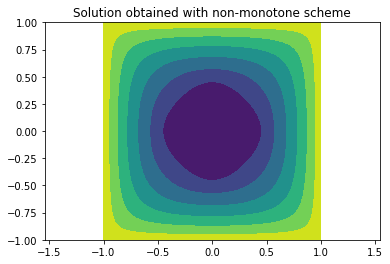

In [10]:
plt.title("Solution obtained with non-monotone scheme")
plt.contourf(*X,solution); plt.axis('equal');

## 2. Monotone discretization by sampling of the control space

We present a numerical scheme based on sampling the control space, which is quite simple and generic. Given fields of positive definite diffusion tensors $D_k(x)$, $1 \leq k \leq K$, without any specific assumption on their origin, we compute the decompositions
$$
    D_k(x) = \sum_{1 \leq i \leq n} \mu_{ki}(x) e_{ki}(x) e_{ki}(x)^T.
$$
We then implement the scheme
$$
    \beta(x) - \min_{1\leq k \leq K} \sum_{1 \leq i \leq n} 
    \mu_{ki}(x) \frac{u(x+h e_{ki}(x))-2 u(x) +u(x-h e_{ki}(x))}{h^2}.
$$

In [11]:
def SchemeSampling(u,diffs,beta,bc):
    # Tensor decomposition 
    coefs,offsets = Selling.Decomposition(diffs)
    
    # Numerical scheme 
    coefs = bc.as_field(coefs)
    residue = beta - (coefs*bc.Diff2(u,offsets)).sum(0).min(0)
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

The tensors involved in our PDE take the following form.

In [12]:
def Diff(alpha,theta):
    e0 = np.array((np.cos(theta),np.sin(theta)))
    e1 = np.array((-np.sin(theta),np.cos(theta)))
    if isinstance(alpha,np.ndarray): 
        e0,e1 = (as_field(e,alpha.shape) for e in (e0,e1))
    return alpha*lp.outer_self(e0) + lp.outer_self(e1)

We also choose a discretization of the control space.

In [13]:
ntheta = 20
thetas = np.linspace(0,np.pi,ntheta,endpoint=False)

We next solve the PDE and display the solution.

In [14]:
params = (Diff(alpha,thetas), beta,bc)
solution = newton_root(SchemeSampling,guess,params)

Iteration: 1  Residue norm: 69.11435896930436
Iteration: 2  Residue norm: 1.6659074845554391
Iteration: 3  Residue norm: 0.2523086292703738
Iteration: 4  Residue norm: 0.055319498200193995
Iteration: 5  Residue norm: 0.0034489933491109737
Iteration: 6  Residue norm: 1.4779288903810084e-12
Target residue reached. Terminating.


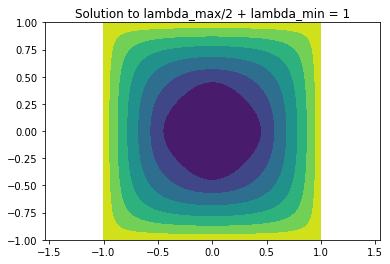

In [15]:
plt.axis('equal'); plt.title('Solution to lambda_max/2 + lambda_min = 1')
plt.contourf(*X,solution);

Since the solution is not explicit, we use the non-monotone numerical scheme to test the result.
We eliminate a layer around the neighborhood of the boundary conditions, where the solution is not smooth.

Max cross-residue of the sampling based numerical solution: 0.05897075265430152


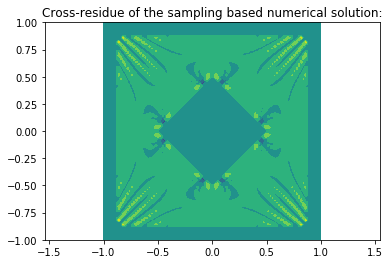

In [16]:
residue_non_monotone = SchemeNonMonotone(solution,alpha,beta,bc)
residue_non_monotone[BoundaryNeighborhood(bc.interior,width=5)] = 0.
print("Max cross-residue of the sampling based numerical solution:",norm(residue_non_monotone,ord=np.inf))
plt.axis('equal'); plt.title("Cross-residue of the sampling based numerical solution:")
plt.contourf(*X,residue_non_monotone);

### 2.1 Limit case : $\alpha=1$.

If one chooses $\alpha=1$, then the PDE becomes linear, namely $-\Delta u + \beta = 0$.
In this very specific case, the sampling based and non-monotone scheme coincide, with the usual discretization of the laplacian operator.
As a result the Newton method converges in one iteration, and the cross-residue vanishes.

Iteration: 1  Residue norm: 6.821210263296962e-12
Target residue reached. Terminating.


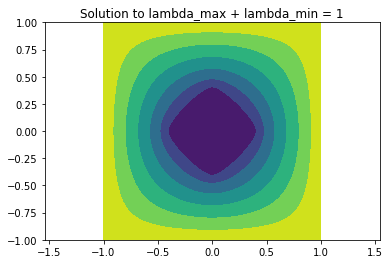

In [17]:
alpha2=1
params = (Diff(alpha2,thetas), beta,bc)
solution = newton_root(SchemeSampling,guess,params)

plt.axis('equal'); plt.title('Solution to lambda_max + lambda_min = 1')
plt.contourf(*X,solution);

In [18]:
print("Cross residue in special case alpha=1 :", norm(SchemeNonMonotone(solution,alpha2,beta,bc),ord=np.inf) )

Cross residue in special case alpha=1 : 6.821210263296962e-12


### 2.2 Limit case : $\alpha \to 0$

In contrast, if one chooses a very small value of $\alpha$, then the PDE becomes more and more non-linear, which raises numerical difficulties discussed below.
If in addition $\beta = 0$, then we recover PDE characterization of the convex envelope:
$$
    -\lambda_{\min}(\nabla^2 u) = 0
$$

**Numerical challenges.** 
As $\alpha\to 0$, the condition number of the tensors $D_\alpha(\theta)$ increase. A finer sampling of the interval $[0,\pi]$ is required, which increases the numerical cost of the method.
In addition, the width of the discretization stencil increases, and therefore the effective discretization scale is reduced.

**Note on computing the convex envelope.**
The computation of convex envelopes is one of the most central problems in algorithmic geometry. For instance, Voronoi diagrams are deduced from a convex envelope computation in higher dimension.
Extremely efficient software packages are available for this problem, and PDE methods are *not* the recommended way to go.

In [19]:
alpha_small = 0.01
ntheta_small = 50
thetas_small = np.linspace(0,np.pi,ntheta_small,endpoint=False)
beta_cvx_env = 0.

The above parameters turn the solution into the convex envelope of the boundary conditions. Recall that we imposed:
* $u=0$ on the (exterior) square boundary.
* $u=-1$ on the (interior) diamond boundary.

Iteration: 1  Residue norm: 551.0630896255049
Iteration: 2  Residue norm: 9.99194572663879
Iteration: 3  Residue norm: 12.634877848760906
Iteration: 4  Residue norm: 3.5106622455859724
Iteration: 5  Residue norm: 0.7327788585181972
Iteration: 6  Residue norm: 0.10918596570732801
Iteration: 8  Residue norm: 0.0029157371512553596
Iteration: 10  Residue norm: 1.8987381752140556e-05
Iteration: 12  Residue norm: 3.823126651986326e-08
Iteration: 14  Residue norm: 9.96644033424232e-09
Target residue reached. Terminating.


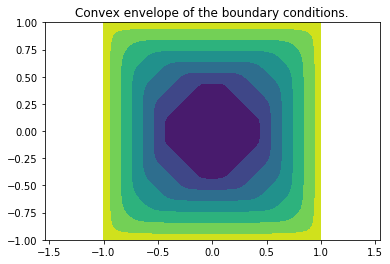

In [20]:
params = (Diff(alpha_small,thetas_small), beta_cvx_env,bc) 
solution = newton_root(SchemeSampling,guess,params)
plt.axis('equal'); plt.title('Convex envelope of the boundary conditions.')
plt.contourf(*X,solution);

The solution is piecewise affine, and its gradient is piecewise constant.
Note in particular that the solution is not twice differentiable, and the equation $-\lambda_{\min}(\nabla^2 u) = 0$ here only has meaning in the sense of viscosity solutions.

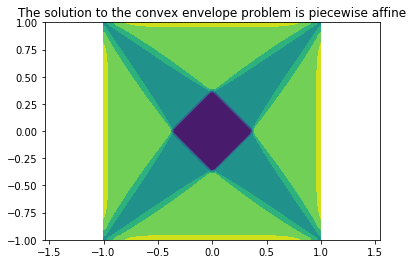

In [21]:
grad = np.array(np.gradient(solution,bc.gridscale))
plt.axis('equal'); plt.title("The solution to the convex envelope problem is piecewise affine")
plt.contourf(*X,norm(grad,ord=2,axis=0));

We next negate the boundary conditions, imposing:
* $u=0$ on the (exterior) square boundary.
* $u=1$ on the (interior) diamond boundary.

This raises an apparent incompatibility: the convex envelope should be $u=0$ on the whole square, yet we impose a distinct value in the diamond. What to expect ?

In [22]:
bc_negated = Domain.MockDirichlet(-bc_grid_values,gridscale,padding=0.)

Iteration: 1  Residue norm: 806.0820465420305
Iteration: 2  Residue norm: 487.71324707786
Iteration: 3  Residue norm: 200.20838090074304
Iteration: 4  Residue norm: 164.3187561466848
Iteration: 5  Residue norm: 111.67932913072397
Iteration: 6  Residue norm: 75.49541847970914
Iteration: 8  Residue norm: 29.94570387126207
Iteration: 10  Residue norm: 1.971756091734278e-13
Target residue reached. Terminating.


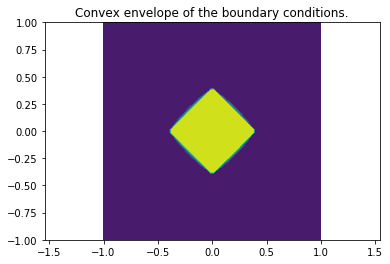

In [23]:
params = (Diff(alpha_small,thetas_small), beta_cvx_env,bc_negated) 
solution = newton_root(SchemeSampling,guess,params)
plt.axis('equal'); plt.title('Convex envelope of the boundary conditions.')
plt.contourf(*X,solution);

The solution to the second order PDE $-\lambda_{\min}(\nabla^2 u)$ is still unique and well defined, in the sense of *viscosity solutions*, with these boundary conditions. It is piecewise constant, with value $u=0$ except on the interior diamond where we impose $u=-1$.

### 2.3 Optimization opportunities

The numerical scheme implemented in this section involves a maximization over a set of diffusion tensors. The size of this set dictates the accuracy of the method, and it may therefore become rather large. In combination with the overhead of sparse AD, this can increase the numerical cost.

We can significantly limit the numerical cost using a technique based on the *envelope theorem*, which proceeds in two steps:
* First run the scheme with ordinary floats, to find out which tensor is active at each grid point.
* Second, run the scheme with AD variables, and and *oracle* providing the active tensors.

**Important : other optimization opportunities.** 
The "optimization" presented in this subsection only serves to illustrate the envelope theorem mechanism. It is *not* effective in terms of computation time, because the optimized part is not dominant. There are other optimization opportunities here, the most obvious one being to avoid recomputing the tensor decompositions at each call of the iterative solver. The choice of linear solver may also be of importance.

In [24]:
def SchemeSampling_OptInner(u,diffs,bc,oracle=None):
    # Select the active tensors, if they are known
    if not(oracle is None):
        diffs = np.take_along_axis(diffs, np.broadcast_to(oracle,diffs.shape[:2]+(1,)+oracle.shape),axis=2)
    
    print("Has AD information :", ad.is_ad(u), ". Number active tensors per point :", diffs.shape[2])
    
    # Tensor decomposition 
    coefs,offsets = Selling.Decomposition(diffs)
    
    # Return the minimal value, and the minimizing index
    return ad.min_argmin( lp.dot_VV(coefs,bc.Diff2(u,offsets)), axis=0)

def SchemeSampling_Opt(u,diffs,beta,bc):
    # Evaluate the operator using the envelope theorem
    result,_ = ad.apply(SchemeSampling_OptInner, u,bc.as_field(diffs),bc, envelope=True)
        
    # Boundary conditions
    return ad.where(bc.interior, beta-result, u-bc.grid_values)

In [25]:
params = (Diff(alpha,thetas), beta,bc)
solution = newton_root(SchemeSampling_Opt,guess,params) 

Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration: 1  Residue norm: 69.11435896930436
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration: 2  Residue norm: 1.6659074845554391
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration: 3  Residue norm: 0.2523086292703738
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration: 4  Residue norm: 0.055319498200193995
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration: 5  Residue norm: 0.0

## 3. Monotone and consistent discretization

Setting up a monotone and consistent discretization requires a bit more work, but is worthwhile in the end if performance and accuracy are a target. Let us recall that the diffusion tensors take the form,
$$
    D_\alpha(\theta) = \alpha\, e(\theta) e(\theta)^T + e(\theta)^\perp (e(\theta)^\perp)^T,
$$
where $0< \alpha \leq 1$ is a fixed parameter in the following, and $\theta \in [0,\pi]$. 

### 3.1 Angular sectors and obtuse superbases
The first, and main, difficulty is to construct a sequence of angles $0 = \theta_0 \leq \cdots \leq \theta_N = \pi$ and of superbases $s_0,\cdots, s_{N-1}$ such that 
$$
    s_k \text{ is } D_\theta(\theta) \text{-obtuse, for all } \theta \in [\theta_k, \theta_{k+1}].
$$
For that purpose, we remark that 
$$
    D_\alpha(\theta) = D_0 + D_1 \cos(2 \theta) + D_2 \sin(2 \theta),
$$
where (omitting the dependency on $\alpha$ for readability)
$$
    D_0 = \frac{\alpha+1} 2
    \begin{pmatrix}
    1 & 0\\
    0 & 1
    \end{pmatrix},
    \quad 
    D_1 = \frac{\alpha-1} 2
    \begin{pmatrix}
    1 & 0\\
    0 &-1
    \end{pmatrix},
    \quad 
    D_2 = \frac{\alpha-1} 2
    \begin{pmatrix}
    0 & 1\\
    1 & 0
    \end{pmatrix}.
$$
Then, for given $u,v \in R^2$, one has 
$$
    <u,D_\alpha(\theta) v> = a_0 + a_1 \cos(2 \theta) + a_2 \sin(2 \theta)
    = r (\cos(2\theta-\phi) - c).
$$
where $a_i = <u,D_i v>$. Then $r e(\phi) = (a_1,a_2)$, and $c=-a_0/r$. We assume that $r$ is positive.
Eventually, the above scalar product is 
* always negative if $c>1$.
* always positive if $c<-1$.
* otherwise, positive iff $|2 \theta-\phi| \leq \arccos(c)$.

In [26]:
def MakeD(alpha):
    return np.moveaxis(0.5*np.array([
        (alpha+1)*np.array([[1,0],[0,1]]),
        (alpha-1)*np.array([[1,0],[0,-1]]),
        (alpha-1)*np.array([[0,1],[1,0]])
    ]), 0,-1)

def NextAngleAndSuperbase(theta,sb,D):
    pairs = np.stack([(1,2), (2,0), (0,1)],axis=1)
    scals = lp.dot_VAV(np.expand_dims(sb[:,pairs[0]],axis=1), 
                       np.expand_dims(D,axis=-1), np.expand_dims(sb[:,pairs[1]],axis=1))
    phi = np.arctan2(scals[2],scals[1])
    cst = -scals[0]/np.sqrt(scals[1]**2+scals[2]**2)
    theta_max = np.pi*np.ones(3)
    mask = cst<1
    theta_max[mask] = (phi[mask]-np.arccos(cst[mask]))/2
    theta_max[theta_max<=0] += np.pi
    theta_max[theta_max<=theta] = np.pi
    k = np.argmin(theta_max)
    i,j = (k+1)%3,(k+2)%3
    return (theta_max[k],np.stack([sb[:,i],-sb[:,j],sb[:,j]-sb[:,i]],axis=1))

def AnglesAndSuperbases(D,maxiter=200):
    sb = Selling.CanonicalSuperbase(2).astype(int)
    thetas=[]
    superbases=[]
    theta=0
    for i in range(maxiter):
        thetas.append(theta)
        if(theta>=np.pi): break
        superbases.append(sb)
        theta,sb = NextAngleAndSuperbase(theta,sb,D)
    return np.array(thetas), np.stack(superbases,axis=2)

The above code is a bit intricate, but its purpose is simple : split the interval $[0,\pi]$ into sub-intervals on which the support of Selling's decomposition of the tensors is fixed and known.

In [27]:
alpha=0.1
thetas,superbases = AnglesAndSuperbases(MakeD(alpha))

In [28]:
thetas

array([0.        , 0.12912139, 0.65627678, 0.91451955, 1.44167494,
       1.57079633, 1.69991771, 2.2270731 , 2.48531588, 3.01247127,
       3.14159265])

In [29]:
superbases

array([[[-1, -1, -1,  0,  0,  1,  0,  0, -1, -1],
        [ 1, -1,  1,  1, -1,  0,  1, -1, -1,  1],
        [ 0,  2,  0, -1,  1, -1, -1,  1,  2,  0]],

       [[-1, -1, -1,  1,  1,  0, -1, -1,  1,  1],
        [ 0,  0,  0,  1, -1, -1, -1,  1,  0,  0],
        [ 1,  1,  1, -2,  0,  1,  2,  0, -1, -1]]])

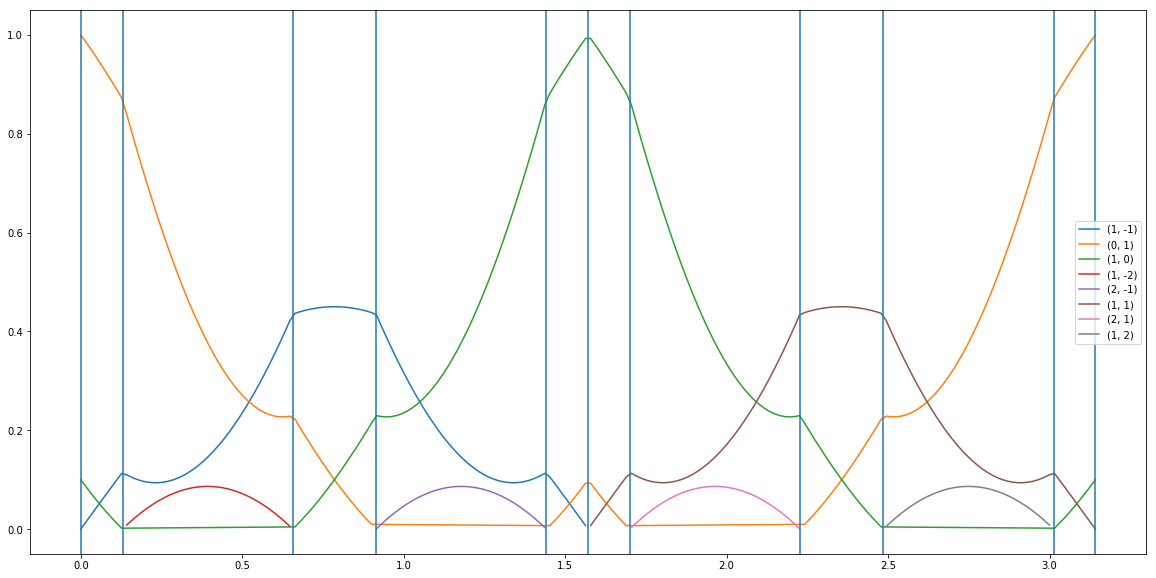

In [30]:
thetas_sampled = np.linspace(0,np.pi,200)
decomp = Selling.GatherByOffset(thetas_sampled,*Selling.Decomposition(Diff(alpha,thetas_sampled)))

plt.figure(figsize=(20,10))
for offset,(angle,coef) in decomp.items():
    plt.plot(angle,coef)
plt.legend(decomp.keys());

for theta in thetas: # Show a vertical line for each angle theta where the stencil changes
    plt.axvline(x=theta);

### 3.2 Optimization over an angular sector

The second step is discretize 
$$
    \min_{\theta \in [\theta_0,\theta_1]} {\rm Tr}(D_\alpha(\theta) \nabla^2 u(x)),
$$
when $D_\alpha(\theta)$ admits the same known obtuse superbase $b = (b_0,b_1,b_2)$ for each $\theta \in [\theta_0,\theta_1]$.

The discretization reads
$$
    \min_{\theta \in [\theta_0, \theta_1]} - \sum_{1 \leq i \leq 3} <b_{i+1}, D_\alpha(\theta) b_{i+2}> \frac{u(x+h b_i^\perp)-2 u(x) + u(x-h b_i^\perp)}{h^2}.
$$
where indices of the superbase are understood modulo $3$.

For that purpose, we rely on the expression $D_\alpha(\theta) = D_0 + D_1 \cos(2 \theta) + D_2 \sin(2 \theta)$, and on the explicit solution 
$$
    \min_{\phi \in [2\theta_0,2\theta_1]} d_0 + d_1 \cos \phi + d_2 \sin \phi = d_0 - \sqrt{d_1^2+d_2^2}
$$
if $(\cos \phi,\sin \phi)$ is proportional to $-(d_1,d_2)$ for some $\phi \in [2\theta_0,2\theta_1]$. Otherwise the minimum is attained at $2\theta_0$ or $2 \theta_1$.

**Theoretical issue for the Newton method** The lack of differentiability of the term $\sqrt{d_1^2+d_2^2}$ is a theoretical issue for the Newton method. It does not raise any difficulty from a practical standpoint, although numpy does raise a warning on the matter.

In [31]:
def MinimizeTrace(u,alpha,bc,sqrt_relax=1e-16):
    # Compute the tensor decompositions
    D=MakeD(alpha)
    theta,sb = AnglesAndSuperbases(D)
    theta = np.array([theta[:-1],theta[1:]])
    
    # Compute the second order differences in the direction orthogonal to the superbase
    sb_rotated = np.array([-sb[1],sb[0]])
    d2u = bc.Diff2(u,sb_rotated)
    d2u[...,bc.not_interior]=0. # Placeholder values to silent NaNs
    
    # Compute the coefficients of the tensor decompositions
    sb1,sb2 = np.roll(sb,1,axis=1), np.roll(sb,2,axis=1)
    sb1,sb2 = (e.reshape( (2,3,1)+sb.shape[2:]) for e in (sb1,sb2))
    D = D.reshape((2,2,1,3,1)+D.shape[3:])
    # Axes of D are space,space,index of superbase element, index of D, index of superbase, and possibly shape of u
    scals = lp.dot_VAV(sb1,D,sb2)

    # Compute the coefficients of the trigonometric polynomial
    scals,theta = (bc.as_field(e) for e in (scals,theta))
    coefs = -lp.dot_VV(scals, np.expand_dims(d2u,axis=1))
    
    # Optimality condition for the trigonometric polynomial in the interior
    value = coefs[0] - np.sqrt(np.maximum(coefs[1]**2+coefs[2]**2,sqrt_relax))
    coefs_ = np.array(coefs) # removed AD information
    angle = np.arctan2(-coefs_[2],-coefs_[1])/2.
    angle[angle<0]+=np.pi
    
    # Boundary conditions for the trigonometric polynomial minimization
    mask = np.logical_not(np.logical_and(theta[0]<=angle,angle<=theta[1]))
    t,c = theta[:,mask],coefs[:,mask]
    value[mask],amin_t = ad.min_argmin(c[0]+c[1]*np.cos(2*t)+c[2]*np.sin(2*t),axis=0)
        
    # Minimize over superbases
    value,amin_sb = ad.min_argmin(value,axis=0)
    
    # Record the optimal angles for future use
    angle[mask]=np.take_along_axis(t,np.expand_dims(amin_t,axis=0),axis=0).squeeze(axis=0) # Min over bc
    angle = np.take_along_axis(angle,np.expand_dims(amin_sb,axis=0),axis=0) # Min over superbases

    return value,angle

def SchemeConsistent(u,alpha,beta,bc):
    value,_ = MinimizeTrace(u,alpha,bc)
    residue = beta - value
    return ad.where(bc.interior,residue,u-bc.grid_values)

The scheme is efficiently solved by the Newton method. The warning (possibly) raised is related with the lack of differentiability of sqrt, as mentioned above. 

In [32]:
%%time
params = (alpha,beta,bc)
guess2 = 0.5*(X[0]**2 +2.*X[1]**2)
solution = newton_root(SchemeConsistent,guess2,params)

Iteration: 1  Residue norm: 106.2675631245285
Iteration: 2  Residue norm: 4.175970377657132
Iteration: 3  Residue norm: 0.9743669771800114
Iteration: 4  Residue norm: 0.2473949412133144
Iteration: 5  Residue norm: 0.036454021423075966
Iteration: 6  Residue norm: 0.00639358995666095
Iteration: 8  Residue norm: 2.991369019156309e-08
Iteration: 9  Residue norm: 1.326050380612287e-12
Target residue reached. Terminating.
CPU times: user 19.6 s, sys: 6.6 s, total: 26.2 s
Wall time: 7.8 s


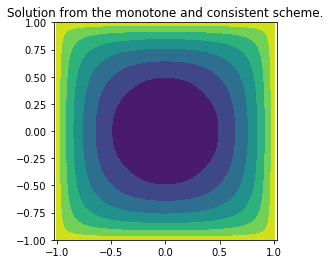

In [33]:
fig = plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("Solution from the monotone and consistent scheme.")
plt.contourf(*X,solution);

In [34]:
savefig(fig,"SolutionMonotoneConsistent.png")

For validation, we compute the residue of the naive scheme. It is small, as expected, except on the boundary of the obstacle.

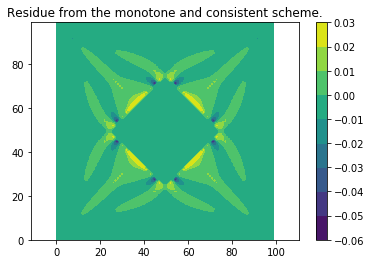

In [35]:
fig = plt.figure(figsize=(6,4)); plt.axis('equal')
plt.title("Residue from the monotone and consistent scheme.")
res = SchemeNonMonotone(solution,*params)
res[BoundaryNeighborhood(bc.interior,width=5)] = 0.
plt.contourf(res); plt.colorbar();

In [36]:
savefig(fig,"ResidueMonotoneConsistent.png")

### 3.3 Optimized implementation

Similarly to the sampling based scheme, we propose an enhanced implementation taking advantage of the envelope theorem, which we recall lets one differentiate functions of the form
$$
    F(x) = \min_{\alpha \in A} F_\alpha(x).
$$
However, there is one important distinction, relative to the nature of the optimization parameter $\alpha \in A$. Indeed, it is:
* *Discrete* in the case of the sampling scheme. Namely the (index of) the optimal angle
* *Continuous* in the case of the consistent scheme. Namely the optimal angle itself.

In [37]:
def MinimizeTrace_Opt(u,alpha,bc,oracle=None):
    if oracle is None:  return MinimizeTrace(u,alpha,bc)
    
    # The oracle contains the optimal angles
    diffs=Diff(alpha,oracle.squeeze(axis=0))
    coefs,sb = Selling.Decomposition(diffs)
    value = lp.dot_VV(coefs,bc.Diff2(u,sb))
    return value,oracle
    

def SchemeConsistent_Opt(u,alpha,beta,bc):
    value,_ = ad.apply(MinimizeTrace_Opt,u,alpha,bc,envelope=True)
    residue = beta - value
    return ad.where(bc.interior,residue,u-bc.grid_values)

In [38]:
%%time
params = (alpha,beta,bc)
guess2 = 0.5*(X[0]**2 +2.*X[1]**2)
solution = newton_root(SchemeConsistent_Opt,guess2,params)

Iteration: 1  Residue norm: 106.26756312453105
Iteration: 2  Residue norm: 4.175970377657768
Iteration: 3  Residue norm: 0.9743669771801633
Iteration: 4  Residue norm: 0.24739494121281247
Iteration: 5  Residue norm: 0.036454021423173555
Iteration: 6  Residue norm: 0.006393589956212975
Iteration: 8  Residue norm: 2.99132353331899e-08
Iteration: 9  Residue norm: 1.1604051053382136e-12
Target residue reached. Terminating.
CPU times: user 4.54 s, sys: 1.16 s, total: 5.7 s
Wall time: 1.94 s


### 3.4 Non-square domains

We illustrate (first order) accurate (Dirichlet) boundary conditions on a general domain. 
This is in contrast with the numerical experiments presented in the above subsections, which rely on a rather crude implementation of the boundary conditions. 

The chosen domain is ring shaped, with a non-smooth boundary including reentrant corners.
The chosen boundary condition is $0$ on the inner boundary, and $1$ on the outer boundary.

In [39]:
outer = Domain.Union(Domain.Ball(),Domain.Box([[0,1],[-1,1]]) )
inner = Domain.AffineTransform(outer,0.4*lp.rotation(np.pi/3))
domain_ring = Domain.Complement(outer,inner)

def bc_value_ring(x):
    """0 on inner boundary, 1 on outer boundary."""
    return outer.level(x)+inner.level(x) > 0

bc_ring = Domain.Dirichlet(domain_ring,bc_value_ring,X)

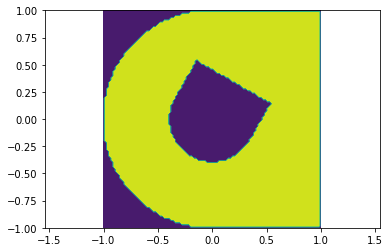

In [40]:
plt.contourf(*X,domain_ring.contains(X)); plt.axis('equal');

Iteration: 1  Residue norm: 87.71412160918013
Iteration: 2  Residue norm: 3.588611918025755
Iteration: 3  Residue norm: 0.20858071879401102
Iteration: 4  Residue norm: 0.009504676464988825
Iteration: 5  Residue norm: 0.00041185762405138073
Iteration: 6  Residue norm: 7.523386892629644e-07
Iteration: 7  Residue norm: 3.1645797093915462e-12
Target residue reached. Terminating.


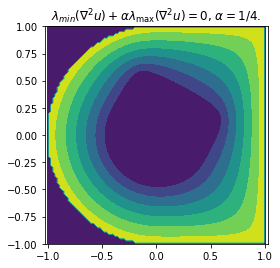

In [41]:
params = (0.5**2,0.,bc_ring)
guess2 = 0.5*(X[0]**2 +2.*X[1]**2)
solution_05 = newton_root(SchemeConsistent_Opt,guess2,params)

fig = plt.figure(figsize=[4,4]);  plt.axis('equal')
plt.title(r"$\lambda_{min}(\nabla^2u)+\alpha\lambda_{\max}(\nabla^2u)=0$, $\alpha=1/4$.")
plt.contourf(*X,solution_05);
savefig(fig,"Consistent_Ring_05.png")

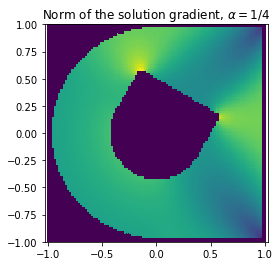

In [42]:
grad = np.array(np.gradient(solution_05,bc_ring.gridscale))
grad[:,np.logical_not(bc_ring.domain.contains_ball(X,1.5*bc.gridscale))]=0.

fig = plt.figure(figsize=[4,4]);  plt.axis('equal')
plt.title(r"Norm of the solution gradient, $\alpha=1/4$")
plt.pcolormesh(*X,norm(grad,ord=2,axis=0)); #plt.colorbar();
savefig(fig,"Consistent_Ring_05_GradNorm.png")

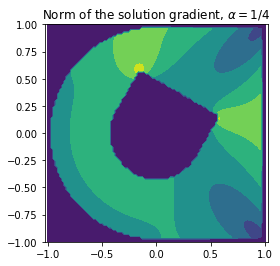

In [43]:
fig = plt.figure(figsize=[4,4]);  plt.axis('equal')
plt.title(r"Norm of the solution gradient, $\alpha=1/4$")
plt.contourf(*X,norm(grad,ord=2,axis=0)); #plt.colorbar();
savefig(fig,"Consistent_Ring_05_GradNorm_Levels.png")

Iteration: 1  Residue norm: 194.9902551187293
Iteration: 2  Residue norm: 38.27470292076112
Iteration: 3  Residue norm: 15.351992164904662
Iteration: 4  Residue norm: 6.635734520481596
Iteration: 5  Residue norm: 2.2868865303012975
Iteration: 6  Residue norm: 0.7152594416761505
Iteration: 8  Residue norm: 0.026452529915589208
Iteration: 10  Residue norm: 0.0007699501224014639
Iteration: 12  Residue norm: 3.2508683184082034e-05
Iteration: 14  Residue norm: 7.098775095677085e-07
Iteration: 15  Residue norm: 6.207531548785276e-09
Target residue reached. Terminating.


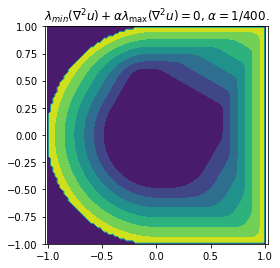

In [44]:
params = (0.05**2,0.,bc_ring)
guess2 = 0.5*(X[0]**2 +2.*X[1]**2)
solution_005 = newton_root(SchemeConsistent_Opt,guess2,params)

fig = plt.figure(figsize=[4,4]);  plt.axis('equal')
plt.title(r"$\lambda_{min}(\nabla^2u)+\alpha\lambda_{\max}(\nabla^2u)=0$, $\alpha=1/400$.")
plt.contourf(*X,solution_005);
savefig(fig,"Consistent_Ring_005.png")

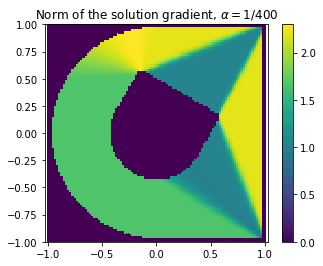

In [45]:
grad = np.array(np.gradient(solution_005,bc.gridscale))
grad[:,np.logical_not(bc_ring.domain.contains_ball(X,1.5*bc.gridscale))]=0.

fig = plt.figure(figsize=[5,4]);  plt.axis('equal')
plt.axis('equal'); plt.title(r"Norm of the solution gradient, $\alpha=1/400$")
plt.pcolormesh(*X,norm(grad,ord=2,axis=0)); plt.colorbar();
savefig(fig,"Consistent_Ring_005_GradNorm.png")

## 4 Validation

The experiments presented below aim at informally validating the numerical implementation, by 
* Comparing the two schemes with one another.
* Comparing with the automatic differentiation of an analytic function. 

### 4.1 Comparaison of the two schemes

The consistent scheme, here denoted $F$, is arguably significantly more complex to implement than numerical scheme based on a sampling of the control space, here denoted $F_n$ where $n$ is the number of samples (angles).

For cross validation, one can observe that for any discrete map $u$, one has 
$$
    F_n(u) = F(u) + O(1/n^2).
$$
Note, crucially, that the test function $u$ is fixed, and so is the grid scale. The continuous limit only takes place in the control space.

In [46]:
np.random.seed(42)
u_random = np.random.uniform(-1,1,guess.shape)

bc_unit = Domain.MockDirichlet(guess.shape,1,padding=0.)

In [47]:
params=(alpha,beta,bc_unit)
residue_consistent = SchemeConsistent(u_random,*params)
def error(ntheta):
    thetas = np.linspace(0,np.pi,ntheta,endpoint=False)
    params=(Diff(alpha,thetas),beta,bc_unit)
    residue_sampling = SchemeSampling(u_random,*params)
    
    return norm(residue_consistent-residue_sampling,ord=np.inf)

In [48]:
ntheta_validation = np.array([2**n for n in range(1,10)])
error_validation = np.array([error(n) for n in ntheta_validation])

Convergence of the sampling based scheme toward the continuous one is observed, with the expected convergence rate.

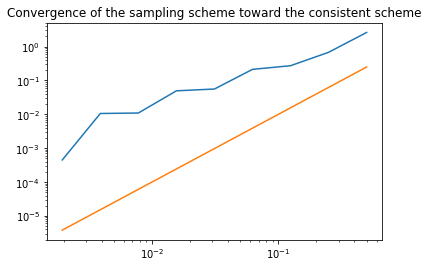

In [49]:
plt.title("Convergence of the sampling scheme toward the consistent scheme")
n_inv = 1./ntheta_validation
plt.loglog(n_inv,error_validation,
         n_inv,n_inv**2);

### 4.2 Comparison with automatic differentiation

We rely on automatic differentiation to compute the derivatives of an analytic function, and evaluate the PDE operator of interest. We then compute the numerical scheme residue on a synthetic problem with a known solution.

In [50]:
def Pucci_ad(u,alpha,x):
    """
    Computes alpha*lambda_max(D^2 u) + lambda_min(D^2 u), 
    at the given set of points, by automatic differentiation.
    """
    x_ad = ad.Dense2.identity(constant=x,shape_free=(2,))
    hessian = u(x_ad).hessian()
    
    sdelta = np.sqrt( ((hessian[0,0]-hessian[1,1])/2.)**2 + hessian[0,1]**2 )
    mean = (hessian[0,0]+hessian[1,1])/2.
    lambdaMin,lambdaMax = mean-sdelta,mean+sdelta
    
    return lambdaMin+alpha*lambdaMax

In [51]:
def Residue_ad(u,alpha,dom,X):
    bc = Domain.Dirichlet(dom,u,X)
    rhs = Pucci_ad(u,alpha,X)
    residue = SchemeConsistent(u(X),alpha,rhs,bc)
    residue[bc.not_interior]=0
    return residue

In [52]:
def test_quadratic(x):
    return x[0]**2+x[1]**2
def test_polynomial(x):
    return 0.5*(x[0]**2+x[1]**2)**2


dom_convex = Domain.Union(Domain.Ball(),Domain.Box())
dom_ball = Domain.Ball()
dom_square = Domain.Box()

Because the scheme is second order consistent its residue is zero up to essentially machine precision on the quadratic function. (Note that the relaxation introduced for differentiability of a square root is mainly responsible for the small error).

In [53]:
[norm(Residue_ad(test_quadratic,0.5,dom,X),ord=np.inf) for dom in (dom_convex,dom_ball,dom_square)]

[1.0002291883637326e-08, 1.0003609052233742e-08, 1.0002291883637326e-08]

On the non-quadratic function, we get essentially second order convergence in the $L^1$ averaged norm. A slower convergence rate is achieved in the $L^\infty$ norm, because the finite differences are only first order accurate at the boundary.

In [54]:
aX_25 = np.linspace(-1,1,25)
X_25 = np.array(np.meshgrid(aX_25,aX_25,indexing='ij'))

aX_50 = np.linspace(-1,1,50)
X_50 = np.array(np.meshgrid(aX_50,aX_50,indexing='ij'))

X_100=X

print("Domain (line): convex, ball, square.")
print("Resolution (column) : 25,50,100.\n")
print("Mean residue of exact polynomial solution.")
print(np.array([[
    norm(Residue_ad(test_polynomial,0.5,dom,X),ord=1,averaged=True)
    for X in (X_25,X_50,X_100)]
    for dom in (dom_convex,dom_ball,dom_square)]))

print("Residue of exact polynomial solution in the L^Infinity norm.")
print(np.array([[
    norm(Residue_ad(test_polynomial,0.5,dom,X),ord=np.inf)
    for X in (X_25,X_50,X_100)]
    for dom in (dom_convex,dom_ball,dom_square)]))

Domain (line): convex, ball, square.
Resolution (column) : 25,50,100.

Mean residue of exact polynomial solution.
[[0.01149697 0.00395542 0.00096948]
 [0.01172253 0.00432875 0.00105138]
 [0.00251758 0.00068901 0.00017824]]
Residue of exact polynomial solution in the L^Infinity norm.
[[0.12456117 0.11640453 0.06062434]
 [0.12456117 0.11640453 0.06062434]
 [0.01388889 0.00333195 0.00081624]]
